In [102]:
import pandas as pd
import random
from collections import defaultdict


In [103]:
# Load Excel file
excel_file = 'seating_list.xlsx' 
df = pd.read_excel(excel_file)



# Remove any rows with missing names (as name is essential)
df.dropna(subset=['Name'], inplace=True)

# Drop the rows where the column 'present' equals 0
df= df[df['Present'] != 0]

# Fill missing values for Gender, Active, and Cannot_Walk columns with defaults
df['Gender'] = df['Gender'].fillna('Unknown')  # Replace missing gender with 'Unknown'

# Convert Active and Cannot_Walk to boolean: '1' means True, '0' or missing means False
df['Active'] = df['Active'].fillna(0).astype(int).astype(bool)  # Assume inactive (False) if missing
df['Cannot_Walk'] = df['Cannot_Walk'].fillna(0).astype(int).astype(bool)  # Assume mobile (False) if missing

# Ensure 'Gender' column has consistent values (e.g., 'M' or 'F')
df['Gender'] = df['Gender'].apply(lambda x: 'M' if x.lower() in ['male', 'm'] else ('F' if x.lower() in ['female', 'f'] else 'Unknown'))

# Remove any duplicate rows based on the 'Name' column
df.drop_duplicates(subset=['Name'], inplace=True)

# Final cleaning check
print("Cleaned Data:")
df.head()


Cleaned Data:


,Name,Gender,Active,Cannot_Walk,Present
0,Sakiko Yoshida,F,True,False,1
1,Gemma,F,False,True,1
2,"Shigeyoshi, Ebata",M,False,False,1
3,"Yukimi, Makihara",F,True,False,1
4,"Kyoko, Yamamoto",F,False,False,1


Total PPL today: 23
table needed 6
ALLL people in all list: 
25
distributed_people: 23


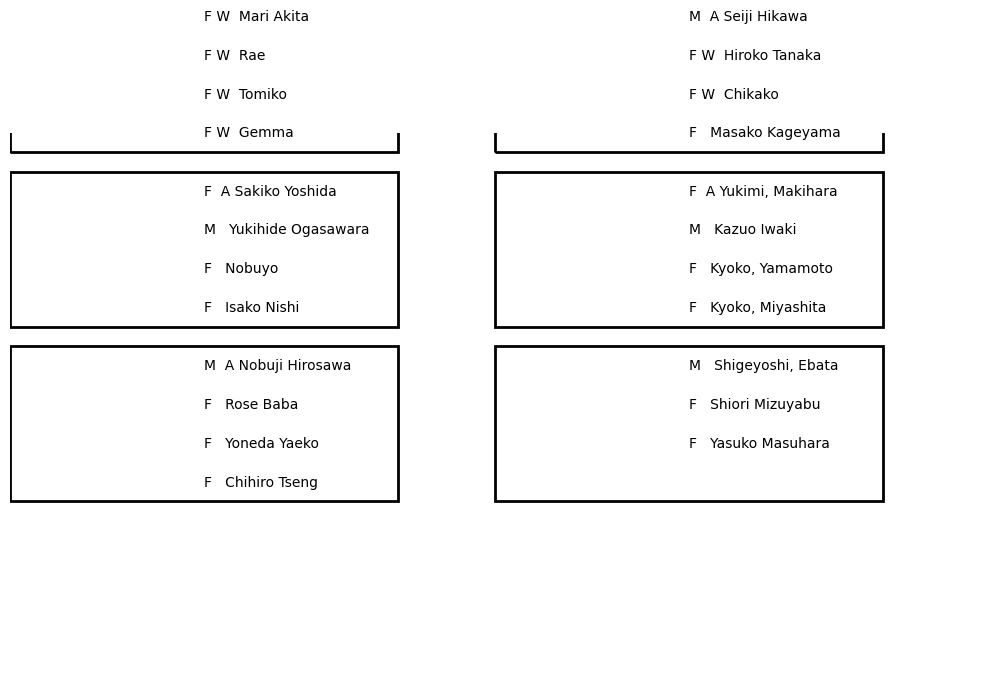

In [164]:
# Shuffle the DataFrame to ensure randomness
df = df.sample(frac=1).reset_index(drop=True)
print("Total PPL today:",len(df))
# Step 1: Decide the number of tables needed
tables_count = (len(df) + 3) // 4  # Calculate needed tables (max 4 per table)
print("table needed",tables_count)
# Create static containers for each table with a capacity of 4
tables = [[] for _ in range(tables_count)]  # Use empty lists instead of None lists

# Step 2: Create a list to store the distributed people
distributed_people = []

# Create lists for each category
cannot_walk_list = df[df['Cannot_Walk']].to_dict('records')
male_list = df[df['Gender'] == 'M'].to_dict('records')
active_list = df[df['Active']].to_dict('records')
other_list = df[~df['Cannot_Walk'] & ~(df['Gender'] == 'M') & ~df['Active']].to_dict('records')

# Shuffle (randomize) each list
random.shuffle(cannot_walk_list)
random.shuffle(male_list)
random.shuffle(active_list)
random.shuffle(other_list)

print("ALLL people in all list: ")
print(len(cannot_walk_list) + len(male_list)+ len(active_list)+len(other_list))

def distribute_people(people_list, category):
    for e, person in enumerate(people_list):
        if person['Name'] not in distributed_people:
            i = (e + 1) % tables_count  # Use the index to determine the initial table
            
            # Find the next available table
            while True:
                if len(tables[i]) < 4:  # Check for an empty spot
                    tables[i].append(person)
                    distributed_people.append(person['Name'])
                    break  # Exit the loop after adding the person
                else:
                    # Move to the next table
                    i = (i + 1) % tables_count  # Circular increment to find the next table


# Distribute active people
distribute_people(active_list, 'active')

def distribute_male_people(people_list):
    for e, person in enumerate(people_list):
        if person['Name'] not in distributed_people:
            i = (e + 1) % tables_count  # Use the index to determine the initial table
            
            # Find the next available table
            while True:
                # Check for an empty spot and if no male is at this table
                if len(tables[i]) < 4 and not any(p['Gender'] == 'M' for p in tables[i]):
                    tables[i].append(person)
                    distributed_people.append(person['Name'])
                    break  # Exit the loop after adding the person
                else:
                    # Move to the next table
                    i = (i + 1) % tables_count  # Circular increment to find the next table


distribute_male_people(male_list)

def distribute_cannot_walk(people_list):
    for person in people_list:
        if person['Name'] not in distributed_people:
            # Start checking from table 0
            i = 0
            
            while True:
                if len(tables[i]) < 4:  # Check for an empty spot
                    tables[i].append(person)
                    distributed_people.append(person['Name'])
                    break  # Exit the loop after adding the person
                else:
                    # Move to the next table (0 or 1, wrapping around)
                    i = (i + 1) % 2  # Only check tables 0 and 1

distribute_cannot_walk(cannot_walk_list)

# Distribute remaining people (who are neither active nor male nor cannot walk)
distribute_people(other_list, 'other')


print("distributed_people:",len(distributed_people))
# # Output the seating arrangement in the specified format
# for i, table in enumerate(tables):
#     print(f"Table {i + 1}:")
#     for person in table:
#         if person is not None:  # Ensure there is a person in the place
#             active = 'A' if person['Active'] else ''
#             cannot_walk = 'W' if person['Cannot_Walk'] else ''
#             print(f"{person['Gender']} {cannot_walk} {person['Name']} {active}".strip())
#     print()  # Newline after each table


import matplotlib.pyplot as plt

# Define table dimensions and spacing
table_width = 200   # Width of each table
row_height = 20     # Height for each row of person details
tables_per_row = 2  # Number of tables per row
spacing_x = 50      # Horizontal spacing between tables
spacing_y = 10      # Vertical spacing between rows

# Create a figure to draw the tables
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size

# Determine maximum number of persons in any table for uniform height
max_persons = max(len(table) for table in tables)

# Loop through tables and draw each one as a rectangle
for i, table in enumerate(tables):
    # Calculate position for each table (row and column)
    row = i // tables_per_row  # Determine which row the table is in
    col = i % tables_per_row   # Determine which column the table is in
    x_pos = col * (table_width + spacing_x)  # Add horizontal spacing
    y_pos = -row * (max_persons * row_height + spacing_y)  # Adjust vertical position based on maximum persons
    
    # Draw the rectangle for the table
    ax.add_patch(plt.Rectangle((x_pos, y_pos), table_width, max_persons * row_height, fill=None, edgecolor='black', linewidth=2))  # Added linewidth for visibility
    
    # Add people inside the table
    for j, person in enumerate(table):
        if person is not None:
            # Prepare the text content
            active = 'A' if person['Active'] else ''
            cannot_walk = 'W' if person['Cannot_Walk'] else ''
            text = f"{person['Gender']} {cannot_walk} {active} {person['Name']} ".strip()

            # Calculate the y position for each person within the table
            person_x = x_pos + table_width / 2  # Center the text horizontally
            person_y = y_pos + max_persons * row_height - (j + 1) * row_height + row_height / 2  # Vertical position
            
            # Place the person's details in the rectangle (centered)
            ax.text(person_x, person_y, text, fontsize=10, ha='left', verticalalignment='center')

# Adjust the limits to fit all tables
ax.set_xlim(0, tables_per_row * (table_width + spacing_x))
ax.set_ylim(-((len(tables) + tables_per_row - 1) // tables_per_row) * (max_persons * row_height + spacing_y), 10)  # Adjust to fit all rows
ax.set_aspect('equal')
plt.axis('off')  # Hide axis for cleaner output

# Display the seating arrangement
plt.tight_layout()  # Automatically adjust spacing
plt.show()


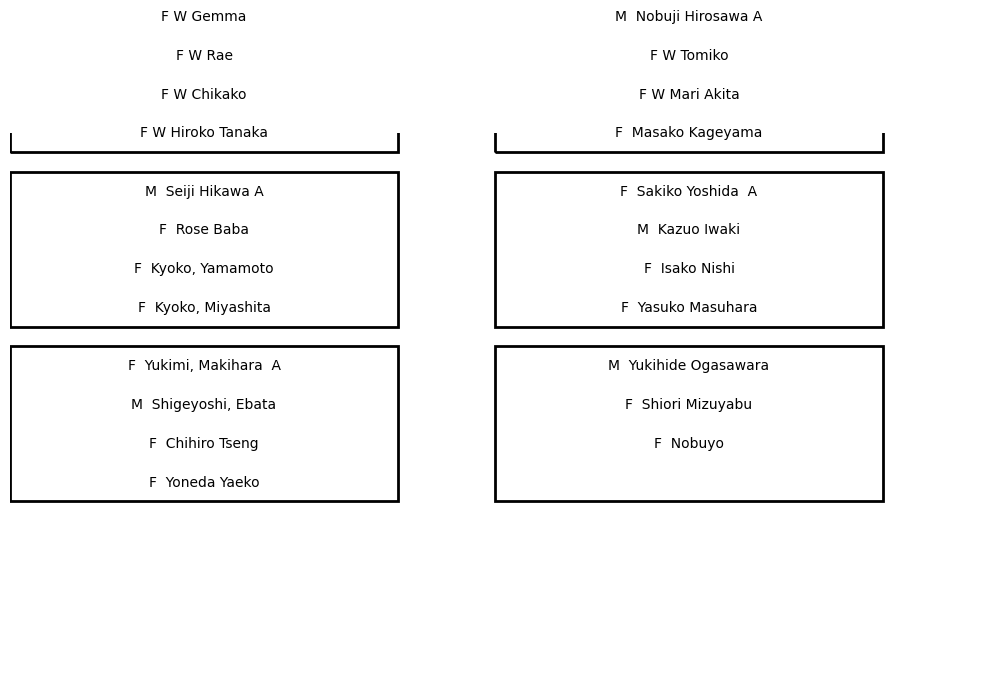

In [138]:
import matplotlib.pyplot as plt

# Define table dimensions and spacing
table_width = 200   # Width of each table
row_height = 20     # Height for each row of person details
tables_per_row = 2  # Number of tables per row
spacing_x = 50      # Horizontal spacing between tables
spacing_y = 10      # Vertical spacing between rows

# Create a figure to draw the tables
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size

# Determine maximum number of persons in any table for uniform height
max_persons = max(len(table) for table in tables)

# Loop through tables and draw each one as a rectangle
for i, table in enumerate(tables):
    # Calculate position for each table (row and column)
    row = i // tables_per_row  # Determine which row the table is in
    col = i % tables_per_row   # Determine which column the table is in
    x_pos = col * (table_width + spacing_x)  # Add horizontal spacing
    y_pos = -row * (max_persons * row_height + spacing_y)  # Adjust vertical position based on maximum persons
    
    # Draw the rectangle for the table
    ax.add_patch(plt.Rectangle((x_pos, y_pos), table_width, max_persons * row_height, fill=None, edgecolor='black', linewidth=2))  # Added linewidth for visibility
    
    # Add people inside the table
    for j, person in enumerate(table):
        if person is not None:
            # Prepare the text content
            active = 'A' if person['Active'] else ''
            cannot_walk = 'W' if person['Cannot_Walk'] else ''
            text = f"{person['Gender']} {cannot_walk} {person['Name']} {active}".strip()

            # Calculate the y position for each person within the table
            person_x = x_pos + table_width / 2  # Center the text horizontally
            person_y = y_pos + max_persons * row_height - (j + 1) * row_height + row_height / 2  # Vertical position
            
            # Place the person's details in the rectangle (centered)
            ax.text(person_x, person_y, text, fontsize=10, ha='center', verticalalignment='center')

# Adjust the limits to fit all tables
ax.set_xlim(0, tables_per_row * (table_width + spacing_x))
ax.set_ylim(-((len(tables) + tables_per_row - 1) // tables_per_row) * (max_persons * row_height + spacing_y), 10)  # Adjust to fit all rows
ax.set_aspect('equal')
plt.axis('off')  # Hide axis for cleaner output

# Display the seating arrangement
plt.tight_layout()  # Automatically adjust spacing
plt.show()


In [105]:
# FORGET IT , REWRITE FOLLOWING MY LOGIC:
# 0 SHUFFLE
# 1 DECIDE TABLE NEEDED
# 2 MAKE A LIST TO STORE THE DISTRIBUTED_PERSON
# 3 DISTRIBUTE TO THE TABLE FOLLOWING RULE:
#     MAX 4 PPL FOR 1 TABLE
#     CANNOT_WALK PPL SHOULD ALL BE AT TABLE 1 OR 2
#     EACH TABLE SHOULD HAS AT LEAST 1  MALE 
#     EACH TABLE SHOULD HAS AT LEAST 1 ACTIVE 
#     ENSURE MAX 4 PPL FOR 1 TABLE
#     REAPEAT THE DISTRIBUTION UNTIL THE ABOVE ARE ALL match
